# Euclid Q1: PHZ catalogs

## Learning Goals

By the end of this tutorial, you will:
- Understand the basic characteristics of Euclid Q1 photo-z catalog and how to match it with MER mosaics.
- Understand what PHZ catalogs are available and how to view the columns in those catalogs.
- How to query with ADQL in the PHZ catalog to find galaxies between a redshift of 1.4 and 1.6.
- Pull and plot a spectrum of one of the galaxies in that catalog.
- Cutout an image of the galaxy to view it close up.
- Learn how to upload images and catalogs to Firefly to inspect individual sources in greater detail.

## Introduction

Euclid launched in July 2023 as a European Space Agency (ESA) mission with involvement by NASA.
The primary science goals of Euclid are to better understand the composition and evolution of the dark Universe.
The Euclid mission is providing space-based imaging and spectroscopy as well as supporting ground-based imaging to achieve these primary goals.
These data will be archived by multiple global repositories, including IRSA, where they will support transformational work in many areas of astrophysics.

Euclid Quick Release 1 (Q1) consists of consists of ~30 TB of imaging, spectroscopy, and catalogs covering four non-contiguous fields:
Euclid Deep Field North (22.9 sq deg), Euclid Deep Field Fornax (12.1 sq deg), Euclid Deep Field South (28.1 sq deg), and LDN1641.

Among the data products included in the Q1 release are multiple catalogs created by the PHZ Processing Function.
This notebook provides an introduction to the main PHZ catalog, which contains 61 columns describing the photometric redshift probability distribution, fluxes, and classification for each source.
If you have questions about this notebook, please contact the [IRSA helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html).

## Imports

In [1]:
# Uncomment the next line to install dependencies if needed.
# !pip install matplotlib 'astropy>=5.3' 'astroquery>=0.4.10' fsspec firefly_client

In [2]:
import os
import re
import urllib

import numpy as np
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.table import QTable
from astropy import units as u
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch, LogStretch, quantity_support
from astropy.wcs import WCS

from firefly_client import FireflyClient
from astroquery.ipac.irsa import Irsa

## 1. Find the MER Tile ID that corresponds to a given RA and Dec

In this case, choose random coordinates to show a different MER mosaic image. Search a radius around these coordinates.

In [3]:
ra = 268
dec = 66
search_radius= 10 * u.arcsec

coord = SkyCoord(ra, dec, unit='deg', frame='icrs')

### Use IRSA to search for all Euclid data on this target

This searches specifically in the euclid_DpdMerBksMosaic "collection" which is the MER images and catalogs.

```{note}
This table lists all MER mosaic images available in this position. These mosaics include the Euclid VIS, Y, J, H images, as well as ground-based telescopes which have been put on the same pixel scale. For more information, see the [Euclid documentation at IPAC](https://euclid.caltech.edu/page/euclid-faq-tech/). We use the ``facility`` argument below to query for Euclid images only. 
```

In [4]:
image_table = Irsa.query_sia(pos=(coord, search_radius), collection='euclid_DpdMerBksMosaic', facility='Euclid')

Note that there are various image types are returned as well, we filter out the science images from these:

In [5]:
science_images = image_table[image_table['dataproduct_subtype'] == 'science']
science_images

s_ra,s_dec,facility_name,instrument_name,dataproduct_subtype,calib_level,dataproduct_type,energy_bandpassname,energy_emband,obs_id,s_resolution,em_min,em_max,em_res_power,proposal_title,access_url,access_format,access_estsize,t_exptime,s_region,obs_collection,obs_intent,algorithm_name,facility_keywords,instrument_keywords,environment_photometric,proposal_id,proposal_pi,proposal_project,target_name,target_type,target_standard,target_moving,target_keywords,obs_release_date,s_xel1,s_xel2,s_pixel_scale,position_timedependent,t_min,t_max,t_resolution,t_xel,obs_publisher_did,s_fov,em_xel,pol_states,pol_xel,cloud_access,o_ucd,upload_row_id
deg,deg,,,,,,,,,arcsec,m,m,,,,,kbyte,s,deg,,,,,,,,,,,,,,,,,,arcsec,,d,d,s,,,deg,,,,,,
float64,float64,object,object,object,int16,object,object,object,object,float64,float64,float64,float64,object,object,object,int64,float64,object,object,object,object,object,object,bool,object,object,object,object,object,bool,bool,object,object,int64,int64,float64,bool,float64,float64,float64,int64,object,float64,int64,object,int64,object,object,int64
267.66769845285177,66.00001388888512,Euclid,NISP,science,3,image,H,Infrared,102159190_NISP,0.1026,1.372e-06,2e-06,2.7,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102159190/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102159190-2E0C34_20241024T211805.202819Z_00.00.fits,image/fits,1474566,--,POLYGON ICRS 268.33021981662876 66.26526742211499 267.0051763768436 66.26526712809576 267.01888399697356 65.73197256576843 268.3165136239277 65.73197285251409 268.33021981662876 66.26526742211499,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102159190_NISP/H,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102159190/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102159190-2E0C34_20241024T211805.202819Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
267.66769845285177,66.00001388888512,Euclid,NISP,science,3,image,Y,Infrared,102159190_NISP,0.0878,9.2e-07,1.146e-06,4.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102159190/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102159190-91C6B0_20241024T212204.431524Z_00.00.fits,image/fits,1474566,--,POLYGON ICRS 268.33021981662876 66.26526742211499 267.0051763768436 66.26526712809576 267.01888399697356 65.73197256576843 268.3165136239277 65.73197285251409 268.33021981662876 66.26526742211499,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102159190_NISP/Y,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102159190/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102159190-91C6B0_20241024T212204.431524Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
267.66769845285177,66.00001388888512,Euclid,NISP,science,3,image,J,Infrared,102159190_NISP,0.094,1.146e-06,1.372e-06,5.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102159190/NISP/EUC_MER_BGSUB-MOSAIC-NIR-J_TILE102159190-466EA5_20241024T213358.873569Z_00.00.fits,image/fits,1474566,--,POLYGON ICRS 268.33021981662876 66.26526742211499 267.0051763768436 66.26526712809576 267.01888399697356 65.73197256576843 268.3165136239277 65.73197285251409 268.33021981662876 66.26526742211499,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102159190_NISP/J,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102159190/NISP/EUC_MER_BGSUB-MOSAIC-NIR-J_TILE102159190-466EA5_20241024T213358.873569Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
267.66769845285177,66.00001388888512,Euclid,VIS,science,3,image,VIS,Optical,102159190_VIS,0.16,5.5e-07,9e-07,2.1,Euclid on-the-fly,https://irsa.ipac.cal

Choose the VIS image and pull the filename and tileID

In [6]:
filename = science_images[science_images['energy_bandpassname'] == 'VIS']['access_url'][0]
tileID = science_images[science_images['energy_bandpassname'] == 'VIS']['obs_id'][0][:9]

print(f'The MER tile ID for this object is : {tileID}')

The MER tile ID for this object is : 102159190


## 2. Download PHZ catalog from IRSA

Use IRSA's TAP to search catalogs

In [7]:
Irsa.list_catalogs(filter='euclid')

{'euclid_q1_mer_catalogue': 'Euclid Q1 MER Catalog',
 'euclid_q1_mer_morphology': 'Euclid Q1 MER Morphology',
 'euclid_q1_mer_cutouts': 'Euclid Q1 MER Cutouts',
 'euclid_q1_phz_photo_z': 'Euclid Q1 PHZ Photo-z Catalog',
 'euclid_q1_phz_classification': 'Euclid Q1 PHZ Classification Catalog',
 'euclid_q1_phz_galaxy_sed': 'Euclid Q1 PHZ Galaxy SED Catalog',
 'euclid_q1_phz_star_sed': 'Euclid Q1 PHZ Star SED Catalog',
 'euclid_q1_phz_star_template': 'Euclid Q1 PHZ Star Template Catalog',
 'euclid_q1_spectro_zcatalog_spe_quality': 'Euclid Q1 SPE Redshift Catalog - Quality',
 'euclid_q1_spectro_zcatalog_spe_classification': 'Euclid Q1 SPE Redshift Catalog - Classification',
 'euclid_q1_spectro_zcatalog_spe_galaxy_candidates': 'Euclid Q1 SPE Redshift Catalog - Galaxy Candidates',
 'euclid_q1_spectro_zcatalog_spe_star_candidates': 'Euclid Q1 SPE Redshift Catalog - Star Candidates',
 'euclid_q1_spectro_zcatalog_spe_qso_candidates': 'Euclid Q1 SPE Redshift Catalog - QSO Candidates',
 'euclid_q1

In [8]:
table_mer = 'euclid_q1_mer_catalogue'
table_phz = 'euclid_q1_phz_photo_z'
table_1dspectra = 'euclid.objectid_spectrafile_association_q1'

### Learn some information about the photo-z catalog:

- How many columns are there?
- List the column names

In [9]:
columns_info = Irsa.list_columns(catalog=table_phz)
print(len(columns_info))

67


```{tip}
The PHZ catalog contains 67 columns, below are a few highlights:

- object_id
- flux_vis_unif, flux_y_unif, flux_j_unif, flux_h_unif
- median redshift (phz_median)
- phz_classification
- phz_90_int1,  phz_90_int2 (The phz PDF interval containing 90% of the probability, upper and lower values)
```

In [10]:
# Full list of columns and their description
columns_info

{'object_id': 'Unique ID of the object in the survey, as set by MER',
 'phz_median': 'The median of the PHZ PDF',
 'phz_mode_1': 'The first mode of the PHZ PDF',
 'phz_mode_1_area': 'The total area of the first mode',
 'phz_mode_2': 'The second mode of the PHZ PDF',
 'phz_mode_2_area': 'The total area of the second mode',
 'bias_id': 'The identifier to be used for retrieving the bias correction shift from the bias correction map',
 'tom_bin_id': 'The identifier of the tomographic bin the source belongs to (Equipopulated-bins)',
 'alt_tom_bin_id': 'The identifier of the alternate tomographic bin the source belongs to (Equidistant-bins)',
 'pos_tom_bin_id': 'The identifier of the photometric clustering tomographic bin the source belongs to (Equipopulated-bins)',
 'flag_som_tomobin': 'Flag telling if the source belong to a combination of SOM cell and Tom. bin which can be calibrated (=1) or not (=0).',
 'flag_som_alt_tomobin': 'Flag telling if the source belong to a combination of SOM cel

```{note}
The phz_catalog on IRSA has more columns than it does on the ESA archive.
This is because the ESA catalog stores some information in one column (for example, phz_90_int is stored as [lower, upper], rather than in two separate columns).

The fluxes are different from the fluxes derived in the MER catalog.
The _unif fluxes are: "Unified flux recomputed after correction from galactic extinction and filter shifts".
```

### Find some galaxies between 1.4 and 1.6 at a selected RA and Dec

We specify the following conditions on our search:
- We select just the galaxies where the flux is greater than zero, to ensure the appear in all four of the Euclid MER images.
- Select only objects in a circle (search radius selected below) around our selected RA and Dec
- `phz_classification = 2` means we select only galaxies
- Using the `phz_90_int1` and `phz_90_int2`, we select just the galaxies where the error on the photometric redshift is less than 20%
- Select just the galaxies between a median redshift of 1.4 and 1.6
- We search just a 5 arcminute box around an RA and Dec

Search based on ``tileID``:

In [11]:
######################## User defined section ############################
## How large do you want the image cutout to be?
im_cutout= 5 * u.arcmin

## What is the center of the cutout?
ra_cutout = 267.8
dec_cutout =  66

coords_cutout = SkyCoord(ra_cutout, dec_cutout, unit='deg', frame='icrs')
size_cutout = im_cutout.to(u.deg).value

In [12]:
adql = ("SELECT DISTINCT mer.object_id, mer.ra, mer.dec, "
        "phz.flux_vis_unif, phz.flux_y_unif, phz.flux_j_unif, phz.flux_h_unif, "
        "phz.phz_classification, phz.phz_median, phz.phz_90_int1, phz.phz_90_int2 "
        f"FROM {table_mer} AS mer "
        f"JOIN {table_phz} as phz "
        "ON mer.object_id = phz.object_id "
        "WHERE 1 = CONTAINS(POINT('ICRS', mer.ra, mer.dec), "
                            f"BOX('ICRS', {ra_cutout}, {dec_cutout}, {size_cutout/np.cos(coords_cutout.dec)}, {size_cutout})) "
        "AND phz.flux_vis_unif> 0 "
        "AND  phz.flux_y_unif > 0 "
        "AND phz.flux_j_unif > 0 "
        "AND phz.flux_h_unif > 0 "
        "AND phz.phz_classification = 2 "
        "AND ((phz.phz_90_int2 - phz.phz_90_int1) / (1 + phz.phz_median)) < 0.20 "
        "AND phz.phz_median BETWEEN 1.4 AND 1.6")


## Use TAP with this ADQL string
result_galaxies = Irsa.query_tap(adql).to_table()
result_galaxies[:5]

object_id,ra,dec,flux_vis_unif,flux_y_unif,flux_j_unif,flux_h_unif,phz_classification,phz_median,phz_90_int1,phz_90_int2
NA,deg,deg,uJy,uJy,uJy,uJy,,,,
int64,float64,float64,float64,float64,float64,float64,int64,float32,float32,float32
2678009942660367473,267.8009942,66.03674732,0.7179743124,2.652854347,3.846100812,5.242284889,2,1.519999981,1.350000024,1.75
2678076394659719061,267.8076394,65.9719062,1.432410411,3.936189211,4.907444279,6.222690821,2,1.600000024,1.480000019,1.820000052
2677585153659610182,267.7585153,65.96101826,0.9337781689,3.119727456,3.711064298,4.959729567,2,1.5,1.379999995,1.710000038
2678000211660381851,267.8000212,66.03818515,1.05509166,2.605535558,3.240129863,3.793176892,2,1.600000024,1.470000029,1.889999986
2678361447659819278,267.8361447,65.98192782,1.99473143,4.426665941,5.28416351,6.400697455,2,1.519999981,1.429999948,1.850000024


```{warning}
Note that we use `to_table` above rather than `to_qtable`. While astropy's `QTable` is more powerful than its `Table`, as it e.g. handles the column units properly, we cannot use it here due to a known bug; it mishandles the large integer numbers in the `object_id` column and recast them as float during which process some precision is being lost. 

Once the bug is fixed, we plan to update the code in this notebook and simplify some of the approaches below.
```

## 3. Read in a cutout of the MER image from IRSA directly

Due to the large field of view of the MER mosaic, let's cut out a smaller section (5'x5') of the MER mosaic to inspect the image.

In [13]:
## Use fsspec to interact with the fits file without downloading the full file
hdu = fits.open(filename, use_fsspec=True)

## Store the header
header = hdu[0].header

## Read in the cutout of the image that you want
cutout_image = Cutout2D(hdu[0].section, position=coords_cutout, size=im_cutout, wcs=WCS(header))

In [14]:
cutout_image.data.shape

(3000, 3000)

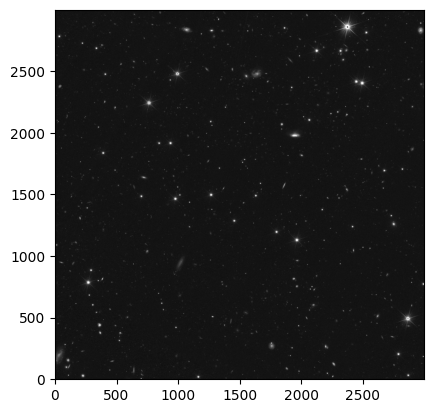

In [15]:
norm = ImageNormalize(cutout_image.data, interval=PercentileInterval(99.9), stretch=AsinhStretch())
_ = plt.imshow(cutout_image.data, cmap='gray', origin='lower', norm=norm)

## 4. Overplot the catalog on the MER mosaic image

```{tip}
We can rely on astropy's WCSAxes framework for making plots of Astronomical data in Matplotlib. Please note the usage of `projection` and `transform` arguments in the code example below.

For more info, please visit the [WCSAxes documentation](https://docs.astropy.org/en/stable/visualization/wcsaxes/index.html).
```

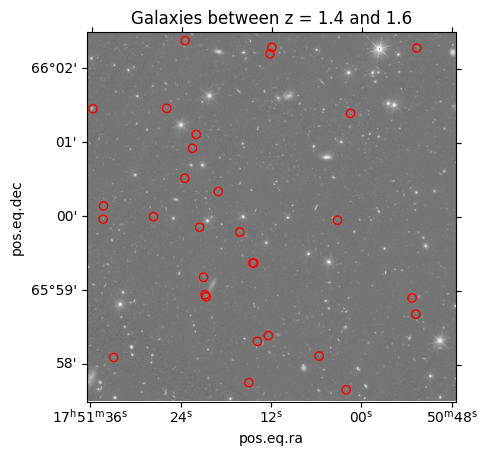

In [16]:
ax = plt.subplot(projection=cutout_image.wcs)

ax.imshow(cutout_image.data, cmap='gray', origin='lower', 
          norm=ImageNormalize(cutout_image.data, interval=PercentileInterval(99.9), stretch=LogStretch()))
plt.scatter(result_galaxies['ra'], result_galaxies['dec'], s=36, facecolors='none', edgecolors='red', 
            transform=ax.get_transform('world'))

_ = plt.title('Galaxies between z = 1.4 and 1.6')

## 5. Pull the spectra on the top brightest source based on object ID

In [17]:
result_galaxies.sort(keys='flux_h_unif', reverse=True)

In [18]:
result_galaxies[:3]

object_id,ra,dec,flux_vis_unif,flux_y_unif,flux_j_unif,flux_h_unif,phz_classification,phz_median,phz_90_int1,phz_90_int2
NA,deg,deg,uJy,uJy,uJy,uJy,,,,
int64,float64,float64,float64,float64,float64,float64,int64,float32,float32,float32
2677562455660233171,267.7562455,66.02331715,0.9376629547,6.932368948,13.77487169,18.16076037,2,1.419999957,1.309999943,1.549999952
2678376290659863203,267.8376291,65.98632035,1.795682573,6.656510568,8.965489634,12.90360126,2,1.539999962,1.49000001,1.610000014
2678016284659732166,267.8016285,65.97321669,1.291915237,5.271049845,7.114689858,10.88637487,2,1.419999957,1.25999999,1.480000019


Let's pick one of these galaxies. Note that the table has been sorted above, we can use the same index here and below to access the data for this particular galaxy.

In [19]:
index = 2

obj_id = result_galaxies['object_id'][index]
redshift = result_galaxies['phz_median'][index]

We will use TAP and an ASQL query to find the spectral data for this particular galaxy.

In [20]:
adql_object = f"SELECT * FROM {table_1dspectra} WHERE objectid = {obj_id}"

## Pull the data on this particular galaxy
result_spectra = Irsa.query_tap(adql_object).to_table()
result_spectra

objectid,tileid,uri,hdu,cntr
int64,int64,object,int64,int64
2678016284659732166,102159190,ibe/data/euclid/q1/SIR/102159190/EUC_SIR_W-COMBSPEC_102159190_2024-11-05T16:14:02.114614Z.fits,1525,59948


Pull out the file name from the ``result_spectra`` table:

In [21]:
file_uri = urllib.parse.urljoin(Irsa.tap_url, result_spectra['uri'][0])
file_uri

'https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/SIR/102159190/EUC_SIR_W-COMBSPEC_102159190_2024-11-05T16:14:02.114614Z.fits'

In [22]:
with fits.open(file_uri) as hdul:
    spectrum = QTable.read(hdul[result_spectra['hdu'][0]], format='fits')
    spectrum_header = hdul[result_spectra['hdu'][0]].header

### Now the data are read in, plot the spectrum

```{tip}
As we use astropy.visualization’s quantity_support, matplotlib automatically picks up the axis units from the quantitites we plot.
```

In [23]:
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f4f84729390>

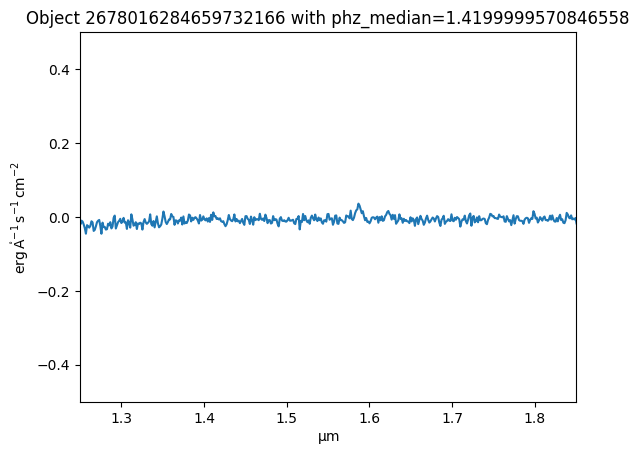

In [24]:
plt.plot(spectrum['WAVELENGTH'].to(u.micron), spectrum['SIGNAL'])

plt.xlim(1.25, 1.85)
plt.ylim(-0.5, 0.5)
_ = plt.title(f"Object {obj_id} with phz_median={redshift}")

Let's cut out a very small patch of the MER image to see what this galaxy looks like. Remember that we sorted the table above, so can reuse the same index to pick up the coordinates for the galaxy. Otherwise we could filter on the object ID.

In [25]:
result_galaxies[index]

object_id,ra,dec,flux_vis_unif,flux_y_unif,flux_j_unif,flux_h_unif,phz_classification,phz_median,phz_90_int1,phz_90_int2
NA,deg,deg,uJy,uJy,uJy,uJy,,,,
int64,float64,float64,float64,float64,float64,float64,int64,float32,float32,float32
2678016284659732166,267.8016285,65.97321669,1.291915237,5.271049845,7.114689858,10.88637487,2,1.419999957,1.25999999,1.480000019


In [26]:
## How large do you want the image cutout to be?
size_galaxy_cutout = 2.0 * u.arcsec

Use the `ra` and `dec` columns for the galaxy to create a `SkyCoord`.

In [27]:
coords_galaxy = SkyCoord(result_galaxies['ra'][index], result_galaxies['dec'][index], unit='deg')

In [28]:
coords_galaxy

<SkyCoord (ICRS): (ra, dec) in deg
    (267.80162845, 65.97321669)>

We haven't closed the image file above, so use `Cutout2D` again to cut out a section around the galaxy.

In [29]:
cutout_galaxy = Cutout2D(hdu[0].section, position=coords_galaxy, size=size_galaxy_cutout, wcs=WCS(header))

Plot to show the cutout on the galaxy

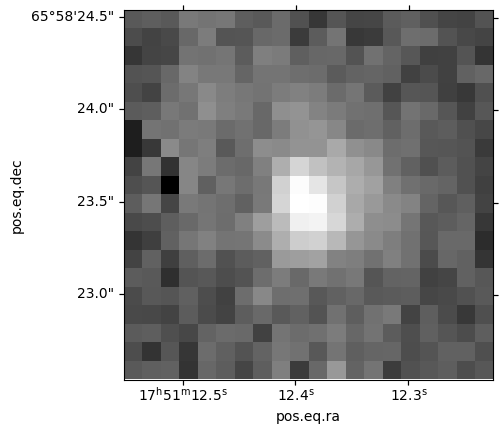

In [30]:
ax = plt.subplot(projection=cutout_galaxy.wcs)

ax.imshow(cutout_galaxy.data, cmap='gray', origin='lower', 
          norm=ImageNormalize(cutout_galaxy.data, interval=PercentileInterval(99.9), stretch=AsinhStretch()))

## 6. Load the image on Firefly to be able to interact with the data directly

Save the data locally if you have not already done so, in order to upload to IRSA viewer.

In [31]:
download_path = "data"
if os.path.exists(download_path):
    print("Output directory already created.")
else:
    print("Creating data directory.")
    os.mkdir(download_path)

Creating data directory.


### Vizualize the image with Firefly

First initialize the client, then set the path to the image, upload it to firefly, load it and align with WCS.

Note this can take a while to upload the full MER image.

In [32]:
fc = FireflyClient.make_client('https://irsa.ipac.caltech.edu/irsaviewer')

fc.show_fits(url=filename)

fc.align_images(lock_match=True)

{'success': True}

### Save the table as a CSV for Firefly upload

In [33]:
csv_path = os.path.join(download_path, "mer_df.csv")
result_galaxies.write(csv_path, format="csv")

### Upload the CSV table to Firefly and display as an overlay on the FITS image

In [34]:
uploaded_table = fc.upload_file(csv_path)
print(f"Uploaded Table URL: {uploaded_table}")

fc.show_table(uploaded_table)

Uploaded Table URL: ${upload-dir}/upload_2786796129973155246_mer_df.csv


{'success': True}

## About this Notebook

**Author**: Tiffany Meshkat, Anahita Alavi, Anastasia Laity, Andreas Faisst, Brigitta Sipőcz, Dan Masters, Harry Teplitz, Jaladh Singhal, Shoubaneh Hemmati, Vandana Desai

**Updated**: 2025-04-10

**Contact:** [the IRSA Helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) with questions or reporting problems.